# Data Preparing

In [1]:
!pip install datasets -q

In [2]:
!pip install "jax[tpu]" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html


Looking in links: https://storage.googleapis.com/jax-releases/libtpu_releases.html


In [3]:
import datasets


datasets.disable_caching()

dataset = datasets.load_dataset('wikitext', 'wikitext-2-raw-v1', split='train[:1%]')

train_test_split = dataset.train_test_split(test_size=0.2)
train_set = train_test_split['train']
test_set = train_test_split['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
from transformers import OpenAIGPTTokenizer


tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=64)

tokenized_train_set = train_set.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_test_set = test_set.map(tokenize_function, batched=True, remove_columns=["text"])

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


Map:   0%|          | 0/293 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

In [5]:
tokenized_train_set

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 293
})

In [6]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, tokenized_dataset):
        self.dataset = tokenized_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            'input_ids': torch.tensor(item['input_ids'], dtype=torch.int32),
            'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.int32)
        }

train_dataset = CustomDataset(tokenized_train_set)
test_dataset = CustomDataset(tokenized_test_set)

In [7]:
train_dataset.dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 293
})

In [8]:
from torch.utils.data import DataLoader


# 데이터 로더 생성
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [9]:
for bat in train_dataloader:
    print(bat)
    break

{'input_ids': tensor([[  303,   303,   303,  ..., 40478, 40478, 40478],
        [40478, 40478, 40478,  ..., 40478, 40478, 40478],
        [40478, 40478, 40478,  ..., 40478, 40478, 40478],
        ...,
        [ 5210,   987,   867,  ...,  5838,   498,  2007],
        [ 9630,  4173,   485,  ...,   240,   557,  2890],
        [ 6330, 14302,   498,  ..., 40478, 40478, 40478]], dtype=torch.int32), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}


# Modeling

In [10]:
from flax import nnx


class Embeddings(nnx.Module):
    def __init__(self, n_vocab, n_tokens, d_out, dropout_rate, rngs):
        self.word_embeddings = nnx.Embed(num_embeddings=n_vocab,
                                         features=d_out,
                                         rngs=rngs)
        self.position_embeddings = nnx.Embed(num_embeddings=n_tokens,
                                            features=d_out,
                                            rngs=rngs)
        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)
        self.n_tokens = n_tokens

    def __call__(self, x):
        word_embed = self.word_embeddings(x)
        position_embed = jnp.arange(self.n_tokens)[None, :]
        position_embed = self.position_embeddings(x)

        return self.dropout(word_embed + position_embed)


In [11]:
import jax.numpy as jnp


class MultiHeadAttention(nnx.Module):
    def __init__(self, n_heads, d_model, dropout_rate, rngs):
        self.n_heads = n_heads
        self.d_model = d_model

        assert d_model % n_heads == 0

        self.d_head = d_model // n_heads

        self.wq = nnx.Linear(d_model, d_model, rngs=rngs)
        self.wk = nnx.Linear(d_model, d_model, rngs=rngs)
        self.wv = nnx.Linear(d_model, d_model, rngs=rngs)
        self.wo = nnx.Linear(d_model, d_model, rngs=rngs)

    def __call__(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        query = self.wq(query)
        key = self.wk(key)
        value = self.wv(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        attention_scores = jnp.einsum("...qhd,...khd->...hqk", query, key)
        attention_scores = attention_scores / jnp.sqrt(self.d_head)
        if mask is not None:
            attention_mask = mask[:, :, None, None]
            attention_scores = attention_scores + attention_mask


        # scaled_attention_logits = jnp.matmul(query, jnp.transpose(key,  (0, 1, 3, 2))) / (self.d_head ** 0.5)
        # if mask is not None:
        #     scaled_attention_logits += (mask * -1e9)

        attention_weights = nnx.softmax(attention_scores, axis=-1)

        output = jnp.einsum("...hqk,...khd->...qhd", attention_weights, value)
        # output = jnp.matmul(attention_weights, value)
        output = jnp.transpose(output, (0, 2, 1, 3))  # (batch_size, seq_len, num_heads, depth)
        output = output.reshape(batch_size, -1, self.d_model)  # (batch_size, -1, d_model)
        output = self.wo(output)

        return output

    def split_heads(self, x, batch_size):
        # 마지막 차원을 num_heads로 분할하고 차원 재배열
        x = x.reshape(batch_size, -1, self.n_heads, self.d_head)  # (batch_size, seq_len, num_heads, depth)
        return jnp.transpose(x, (0, 2, 1, 3))  # (batch_size, num_heads, seq_len, depth)


In [12]:
class TransformerBlock(nnx.Module):
    def __init__(self, d_embed, n_heads, d_ffn, dropout_rate, rngs):
        self.attention = MultiHeadAttention(n_heads, d_embed, dropout_rate, rngs=rngs)

        self.layernorm1 = nnx.LayerNorm(num_features=d_embed, rngs=rngs)
        self.layernorm2 = nnx.LayerNorm(num_features=d_embed, rngs=rngs)

        self.ffn1 = nnx.Linear(d_embed, d_ffn, rngs=rngs)
        self.ffn2 = nnx.Linear(d_ffn, d_embed, rngs=rngs)

        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)

    def __call__(self, x, mask=None):
        attention_output = self.attention(x, x, x, mask)
        attention_output += x
        attention_output = self.layernorm1(attention_output)

        # PositionwiseFeedForward
        output = self.ffn1(attention_output)
        output = nnx.relu(output)
        output = self.dropout(output)
        output = self.ffn2(output)
        output += attention_output

        output = self.layernorm2(output)

        return output


In [13]:
class GPT(nnx.Module):
    def __init__(self, n_vocab, n_tokens, d_out,
                 n_heads, d_ffn, n_layers,
                 dropout_rate, rngs):
        self.embeddings = Embeddings(n_vocab, n_tokens, d_out, dropout_rate, rngs)
        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)
        self.blocks = [TransformerBlock(d_out, n_heads, d_ffn, dropout_rate, rngs)
                      for _ in range(n_layers)]

        self.out = nnx.Linear(d_out, d_out, rngs=rngs)
        self.n_layers = n_layers

    def __call__(self, x, mask):
        x = self.embeddings(x)
        x = self.dropout(x)

        for i in range(self.n_layers):
            x = self.blocks[i](x, mask)

        x = self.out(x)
        return x


# Training

In [14]:
# 메모리 문제로 하이퍼파라미터 대폭 축소

model = GPT(n_vocab=6000,
            n_tokens=64,
            d_out=32,
            n_heads=8,
            d_ffn=32,
            n_layers=3,
            dropout_rate=0.1,
            rngs=nnx.Rngs(0))



In [15]:
nnx.display(model)


GPT(
  embeddings=Embeddings(
    word_embeddings=Embed(
      embedding=Param(
        value=Array(shape=(6000, 32), dtype=float32)
      ),
      num_embeddings=6000,
      features=32,
      dtype=dtype('float32'),
      param_dtype=<class 'jax.numpy.float32'>,
      embedding_init=<function variance_scaling.<locals>.init at 0x7cb0d564add0>
    ),
    position_embeddings=Embed(
      embedding=Param(
        value=Array(shape=(64, 32), dtype=float32)
      ),
      num_embeddings=64,
      features=32,
      dtype=dtype('float32'),
      param_dtype=<class 'jax.numpy.float32'>,
      embedding_init=<function variance_scaling.<locals>.init at 0x7cb0d564add0>
    ),
    dropout=Dropout(rate=0.1, broadcast_dims=(), deterministic=False, rng_collection='dropout', rngs=Rngs(
      default=RngStream(
        key=RngKey(
          value=Array(shape=(), dtype=key<fry>),
          tag='default'
        ),
        count=RngCount(
          value=Array(shape=(), dtype=uint32),
          tag='de

In [16]:
# @nnx.jit
def loss_fn(model, batch):
        logits  = model(
            batch['input_ids'],
            batch['attention_mask']
        )
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, batch['input_ids']).mean()
        return loss, (logits, batch['input_ids'])

@nnx.jit
def train_step(model, optimizer, metrics, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, (logits, labels)), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=labels)
    optimizer.update(grads)

@nnx.jit
def eval_step(model, metrics, batch):
    loss, (logits, labels) = loss_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=labels)



In [17]:
import optax

learning_rate = 0.005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

In [20]:
metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
}

train_steps = 1200
eval_every = 200
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch['input_ids'] = jnp.array(batch['input_ids'])
        batch['attention_mask'] = jnp.array(batch['attention_mask'])
        train_step(model, optimizer, metrics, batch)

    for metric, value in metrics.compute().items():
        metrics_history[f'train_{metric}'].append(value)
    metrics.reset()

    model.eval()
    for test_batch in test_dataloader:
        test_batch['input_ids'] = jnp.array(test_batch['input_ids'])
        test_batch['attention_mask'] = jnp.array(test_batch['attention_mask'])
        eval_step(model, metrics, test_batch)

    for metric, value in metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)
    metrics.reset()

    print(
        f"[train] epoch: {epoch+1}, "
        f"loss: {metrics_history['train_loss'][-1]}, "
        f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
    )
    print(
        f"[test] epoch: {epoch+1}, "
        f"loss: {metrics_history['test_loss'][-1]}, "
        f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
    )

[train] epoch: 1, loss: nan, accuracy: 0.3572952151298523
[test] epoch: 1, loss: nan, accuracy: 0.2956081032752991
[train] epoch: 2, loss: nan, accuracy: 0.3572952151298523
[test] epoch: 2, loss: nan, accuracy: 0.2956081032752991
[train] epoch: 3, loss: nan, accuracy: 0.3572952151298523
[test] epoch: 3, loss: nan, accuracy: 0.2956081032752991
[train] epoch: 4, loss: nan, accuracy: 0.3572952151298523
[test] epoch: 4, loss: nan, accuracy: 0.2956081032752991
[train] epoch: 5, loss: nan, accuracy: 0.3572952151298523
[test] epoch: 5, loss: nan, accuracy: 0.2956081032752991


# Visualization

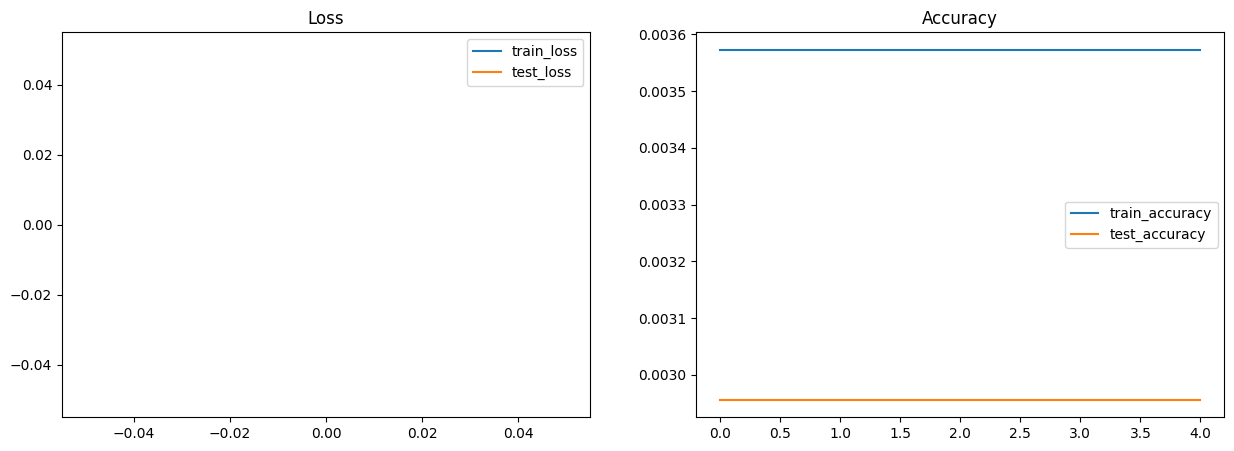

In [21]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()